
# VAE + GP + BO DBTL Pipeline


In [3]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class VAE(nn.Module):
    def __init__(self, input_dim=100, latent_dim=10):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, input_dim), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

Generated 200 training sequences
Sequence shape: torch.Size([200, 100])
Yield range: 0.129 to 1.033
Mean yield: 0.686


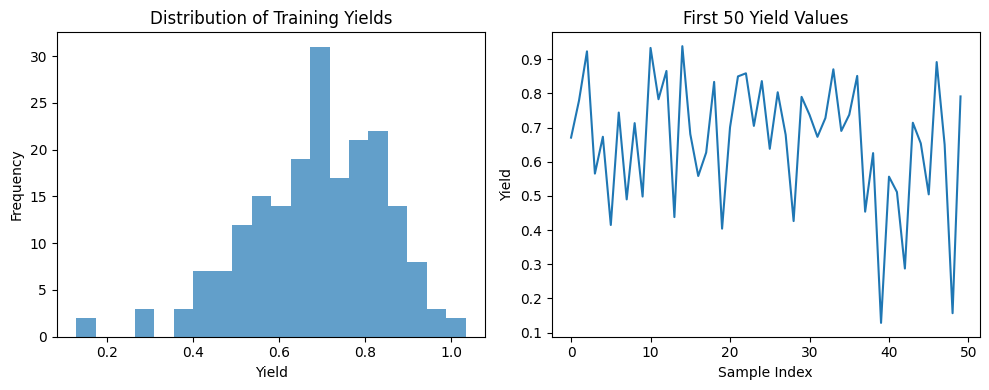

In [4]:
# Generate dummy one-hot encoded sequences (simulating protein/DNA sequences)
def generate_dummy_sequences(n_samples=1000, seq_length=100):
    """Generate dummy one-hot encoded sequences"""
    # 4 nucleotides/amino acids for simplicity (A, T, G, C)
    n_vocab = 4
    
    # Generate random sequences
    sequences = []
    for _ in range(n_samples):
        # Random sequence of length seq_length
        seq_indices = np.random.choice(n_vocab, size=seq_length//n_vocab)
        
        # Convert to one-hot
        one_hot = np.zeros(seq_length)
        for i, idx in enumerate(seq_indices):
            one_hot[i*n_vocab + idx] = 1
        
        sequences.append(one_hot)
    
    return np.array(sequences)

# Generate dummy yield data (simulating experimental results)
def generate_dummy_yields(sequences):
    """Generate dummy yield values based on sequence features"""
    n_samples = len(sequences)
    
    # Simple synthetic function: yield depends on sequence composition
    yields = []
    for seq in sequences:
        # Simple feature: proportion of each base
        base_props = []
        for i in range(4):
            base_props.append(seq[i::4].sum())
        
        # Synthetic yield function (higher yield for balanced sequences)
        balance_score = 1.0 - np.std(base_props) / np.mean(base_props)
        noise = np.random.normal(0, 0.1)
        yield_val = balance_score + noise
        yields.append(max(0, yield_val))  # Ensure non-negative
    
    return np.array(yields)

# Generate training data
n_train = 200
X_train_designs = generate_dummy_sequences(n_train, seq_length=100)
y_train = generate_dummy_yields(X_train_designs)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_designs)
y_train_tensor = torch.FloatTensor(y_train)

print(f"Generated {n_train} training sequences")
print(f"Sequence shape: {X_train_tensor.shape}")
print(f"Yield range: {y_train_tensor.min():.3f} to {y_train_tensor.max():.3f}")
print(f"Mean yield: {y_train_tensor.mean():.3f}")

# Plot yield distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=20, alpha=0.7)
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.title('Distribution of Training Yields')

plt.subplot(1, 2, 2)
plt.plot(y_train[:50])
plt.xlabel('Sample Index')
plt.ylabel('Yield')
plt.title('First 50 Yield Values')
plt.tight_layout()
plt.show()

Training VAE...
Epoch 20/100, Loss: 537.2835
Epoch 40/100, Loss: 536.1211
Epoch 60/100, Loss: 535.5531
Epoch 80/100, Loss: 534.4871
Epoch 40/100, Loss: 536.1211
Epoch 60/100, Loss: 535.5531
Epoch 80/100, Loss: 534.4871
Epoch 100/100, Loss: 533.6817
VAE training completed!
Epoch 100/100, Loss: 533.6817
VAE training completed!


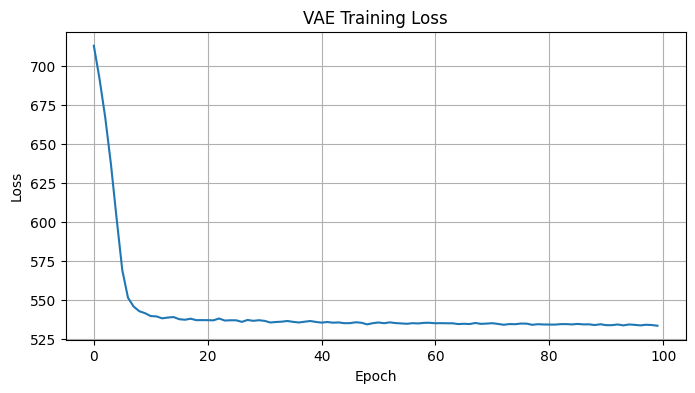

Reconstruction error: 0.1877
Latent space dimensionality: 10
Sample latent means: [-0.02833261  0.00679912  0.07086617  0.04942155  0.04807701]
Sample latent logvars: [-0.00897087 -0.01627759 -0.01082178  0.00867824  0.02800175]


In [5]:
def vae_loss(x_recon, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    
    # KL divergence loss
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kld

# Initialize VAE
input_dim = 100
latent_dim = 10
vae = VAE(input_dim=input_dim, latent_dim=latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Training parameters
batch_size = 32
n_epochs = 100
train_losses = []

print("Training VAE...")
vae.train()

for epoch in range(n_epochs):
    epoch_loss = 0
    n_batches = 0
    
    # Create mini-batches
    for i in range(0, len(X_train_tensor), batch_size):
        x_batch = X_train_tensor[i:i+batch_size]
        
        # Forward pass
        x_recon, mu, logvar = vae(x_batch)
        
        # Compute loss
        loss = vae_loss(x_recon, x_batch, mu, logvar)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}')

print("VAE training completed!")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.grid(True)
plt.show()

# Test reconstruction
vae.eval()
with torch.no_grad():
    x_test = X_train_tensor[:5]
    x_recon, mu, logvar = vae(x_test)
    
    print(f"Reconstruction error: {nn.functional.mse_loss(x_recon, x_test).item():.4f}")
    print(f"Latent space dimensionality: {mu.shape[1]}")
    print(f"Sample latent means: {mu[0, :5].numpy()}")
    print(f"Sample latent logvars: {logvar[0, :5].numpy()}")

Encoding training designs to latent space...
Latent representations shape: torch.Size([200, 10])
Latent mean range: -0.095 to 0.084
Training GP...
Iter 10/50 - Loss: 0.432
Iter 20/50 - Loss: 0.032
Iter 30/50 - Loss: -0.294
Iter 40/50 - Loss: -0.404
Iter 50/50 - Loss: -0.386
GP training completed!


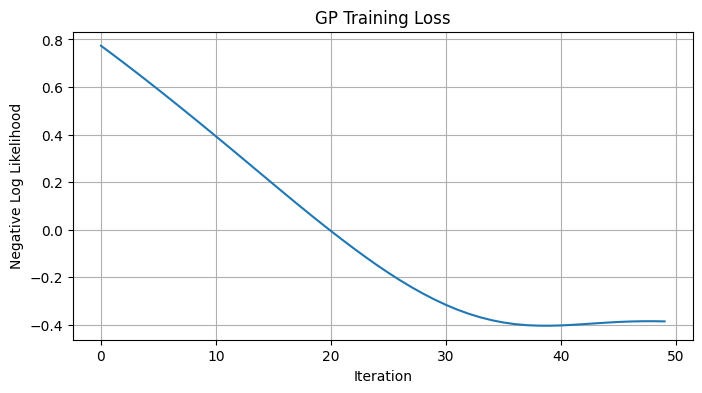

Test predictions vs actual:
  Pred: 0.686 ± 0.011, Actual: 0.671
  Pred: 0.687 ± 0.010, Actual: 0.779
  Pred: 0.688 ± 0.011, Actual: 0.923
  Pred: 0.687 ± 0.011, Actual: 0.565
  Pred: 0.687 ± 0.010, Actual: 0.673

GP hyperparameters:
  Noise: 0.0196
  Lengthscale: 2.2267
  Output scale: 0.0107


In [9]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import ConstantMean

# Encode all training designs to latent space
print("Encoding training designs to latent space...")
vae.eval()
with torch.no_grad():
    latent_mu, latent_logvar = vae.encode(X_train_tensor)
    
print(f"Latent representations shape: {latent_mu.shape}")
print(f"Latent mean range: {latent_mu.min():.3f} to {latent_mu.max():.3f}")

class LatentGP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        cov = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)

# Initialize GP
likelihood = GaussianLikelihood()
gp = LatentGP(latent_mu, y_train_tensor, likelihood)

# Training mode
gp.train()
likelihood.train()

# Use the adam optimizer
optimizer_gp = torch.optim.Adam(gp.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = ExactMarginalLogLikelihood(likelihood, gp)

print("Training GP...")
training_iter = 50
gp_losses = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer_gp.zero_grad()
    
    # Output from model
    output = gp(latent_mu)
    
    # Calc loss and backprop gradients
    loss = -mll(output, y_train_tensor)
    loss.backward()
    
    gp_losses.append(loss.item())
    
    if (i + 1) % 10 == 0:
        print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}')
    
    optimizer_gp.step()

print("GP training completed!")

# Plot GP training loss
plt.figure(figsize=(8, 4))
plt.plot(gp_losses)
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')
plt.title('GP Training Loss')
plt.grid(True)
plt.show()

# Test GP predictions
gp.eval()
likelihood.eval()
with torch.no_grad():
    # Test on training data
    test_x = latent_mu[:10]
    predictions = gp(test_x)
    pred_mean = predictions.mean
    pred_var = predictions.variance
    
    print(f"Test predictions vs actual:")
    for i in range(5):
        print(f"  Pred: {pred_mean[i].item():.3f} ± {pred_var[i].sqrt().item():.3f}, Actual: {y_train_tensor[i].item():.3f}")

print(f"\nGP hyperparameters:")
print(f"  Noise: {likelihood.noise.item():.4f}")
print(f"  Lengthscale: {gp.covar_module.base_kernel.lengthscale.item():.4f}")
print(f"  Output scale: {gp.covar_module.outputscale.item():.4f}")

Optimizing acquisition function in latent space...
Candidate predictions - Mean: 0.693, Std: 0.009
Candidate uncertainties - Mean: 0.093, Std: 0.009
Best observed yield: 1.033
Expected Improvement range: 0.000000 to 0.000021

Top 5 candidates:
  Candidate 1: EI=0.000021, μ=0.709, σ=0.102
  Candidate 2: EI=0.000018, μ=0.702, σ=0.103
  Candidate 3: EI=0.000017, μ=0.711, σ=0.100
  Candidate 4: EI=0.000017, μ=0.703, σ=0.102
  Candidate 5: EI=0.000017, μ=0.701, σ=0.103

Decoded designs shape: torch.Size([5, 100])
Decoded designs range: 0.147 to 0.335


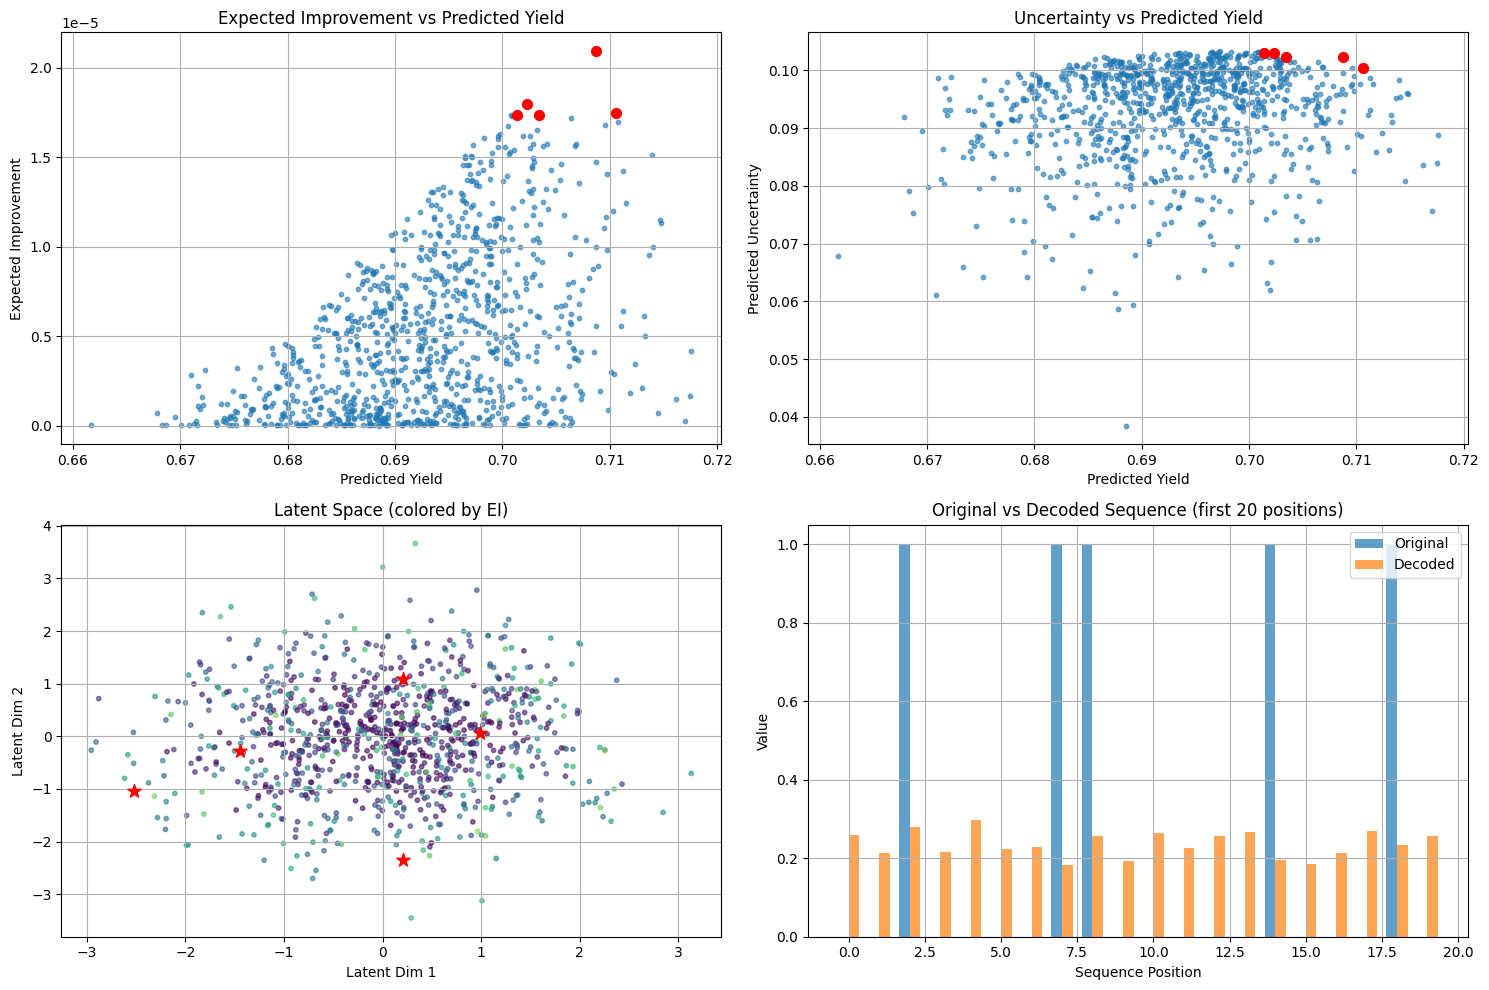


Bayesian optimization completed!
Next 5 experiments suggested based on Expected Improvement
These designs can be synthesized and tested experimentally

DBTL PIPELINE SUMMARY
1. Generated 200 dummy one-hot encoded sequences
2. Trained VAE to compress 100D → 10D latent space
3. Trained GP to model yield in 10D latent space
4. Used Bayesian optimization to find 5 promising candidates
5. Decoded candidates back to 100D design space
6. Ready for experimental validation!


In [7]:
print("Optimizing acquisition function in latent space...")

# Sample latent points from prior (or could use VAE posterior)
n_candidates = 1000
z_candidates = torch.randn(n_candidates, latent_dim)

# Predict with GP
gp.eval()
likelihood.eval()
with torch.no_grad():
    preds = gp(z_candidates)
    mu = preds.mean
    sigma = preds.variance.sqrt()

print(f"Candidate predictions - Mean: {mu.mean():.3f}, Std: {mu.std():.3f}")
print(f"Candidate uncertainties - Mean: {sigma.mean():.3f}, Std: {sigma.std():.3f}")

# Expected Improvement
y_best = y_train_tensor.max()
print(f"Best observed yield: {y_best.item():.3f}")

# Calculate Expected Improvement
improvement = mu - y_best
z_norm = improvement / sigma
ei = improvement * torch.tensor([norm.cdf(z.item()) for z in z_norm]) + sigma * torch.tensor([norm.pdf(z.item()) for z in z_norm])

print(f"Expected Improvement range: {ei.min():.6f} to {ei.max():.6f}")

# Get top candidates
n_top = 5
top_indices = ei.topk(n_top).indices
top_z = z_candidates[top_indices]
top_ei = ei[top_indices]
top_mu = mu[top_indices]
top_sigma = sigma[top_indices]

print(f"\nTop {n_top} candidates:")
for i in range(n_top):
    print(f"  Candidate {i+1}: EI={top_ei[i]:.6f}, μ={top_mu[i]:.3f}, σ={top_sigma[i]:.3f}")

# Decode to real designs
vae.eval()
with torch.no_grad():
    top_designs = vae.decode(top_z)

print(f"\nDecoded designs shape: {top_designs.shape}")
print(f"Decoded designs range: {top_designs.min():.3f} to {top_designs.max():.3f}")

# Visualize the optimization results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Expected Improvement vs predictions
axes[0, 0].scatter(mu.numpy(), ei.numpy(), alpha=0.6, s=10)
axes[0, 0].scatter(top_mu.numpy(), top_ei.numpy(), color='red', s=50, zorder=5)
axes[0, 0].set_xlabel('Predicted Yield')
axes[0, 0].set_ylabel('Expected Improvement')
axes[0, 0].set_title('Expected Improvement vs Predicted Yield')
axes[0, 0].grid(True)

# Plot 2: Uncertainty vs predictions
axes[0, 1].scatter(mu.numpy(), sigma.numpy(), alpha=0.6, s=10)
axes[0, 1].scatter(top_mu.numpy(), top_sigma.numpy(), color='red', s=50, zorder=5)
axes[0, 1].set_xlabel('Predicted Yield')
axes[0, 1].set_ylabel('Predicted Uncertainty')
axes[0, 1].set_title('Uncertainty vs Predicted Yield')
axes[0, 1].grid(True)

# Plot 3: Latent space visualization (2D projection)
axes[1, 0].scatter(z_candidates[:, 0].numpy(), z_candidates[:, 1].numpy(), 
                   c=ei.numpy(), cmap='viridis', alpha=0.6, s=10)
axes[1, 0].scatter(top_z[:, 0].numpy(), top_z[:, 1].numpy(), 
                   color='red', s=100, zorder=5, marker='*')
axes[1, 0].set_xlabel('Latent Dim 1')
axes[1, 0].set_ylabel('Latent Dim 2')
axes[1, 0].set_title('Latent Space (colored by EI)')
axes[1, 0].grid(True)

# Plot 4: Compare original vs decoded designs (first few dimensions)
n_dims_to_show = 20
original_sample = X_train_tensor[0, :n_dims_to_show].numpy()
decoded_sample = top_designs[0, :n_dims_to_show].numpy()

x_pos = np.arange(n_dims_to_show)
width = 0.35

axes[1, 1].bar(x_pos - width/2, original_sample, width, alpha=0.7, label='Original')
axes[1, 1].bar(x_pos + width/2, decoded_sample, width, alpha=0.7, label='Decoded')
axes[1, 1].set_xlabel('Sequence Position')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_title('Original vs Decoded Sequence (first 20 positions)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nBayesian optimization completed!")
print(f"Next {n_top} experiments suggested based on Expected Improvement")
print(f"These designs can be synthesized and tested experimentally")

# Summary of the full pipeline
print(f"\n" + "="*50)
print("DBTL PIPELINE SUMMARY")
print("="*50)
print(f"1. Generated {n_train} dummy one-hot encoded sequences")
print(f"2. Trained VAE to compress {input_dim}D → {latent_dim}D latent space")
print(f"3. Trained GP to model yield in {latent_dim}D latent space")
print(f"4. Used Bayesian optimization to find {n_top} promising candidates")
print(f"5. Decoded candidates back to {input_dim}D design space")
print(f"6. Ready for experimental validation!")
print("="*50)

CONTINUING THE DBTL LOOP
5. Test phase - Simulating experimental results...
Experimental results for top candidates:
  Candidate 1: Yield = 0.850
  Candidate 2: Yield = 0.920
  Candidate 3: Yield = 0.780
  Candidate 4: Yield = 0.880
  Candidate 5: Yield = 0.940

6. Learn phase - Updating dataset...
Updated training set size: 205 designs
New best yield: 1.033

7. Ready for next DBTL cycle!
   - Re-encode all designs to latent space
   - Retrain GP with updated dataset
   - Run BO to find next batch of candidates
   - Repeat until convergence or resource limits

Improvement achieved:
  Initial best yield: 1.033
  After 1 DBTL cycle: 1.033
  Improvement: 0.000


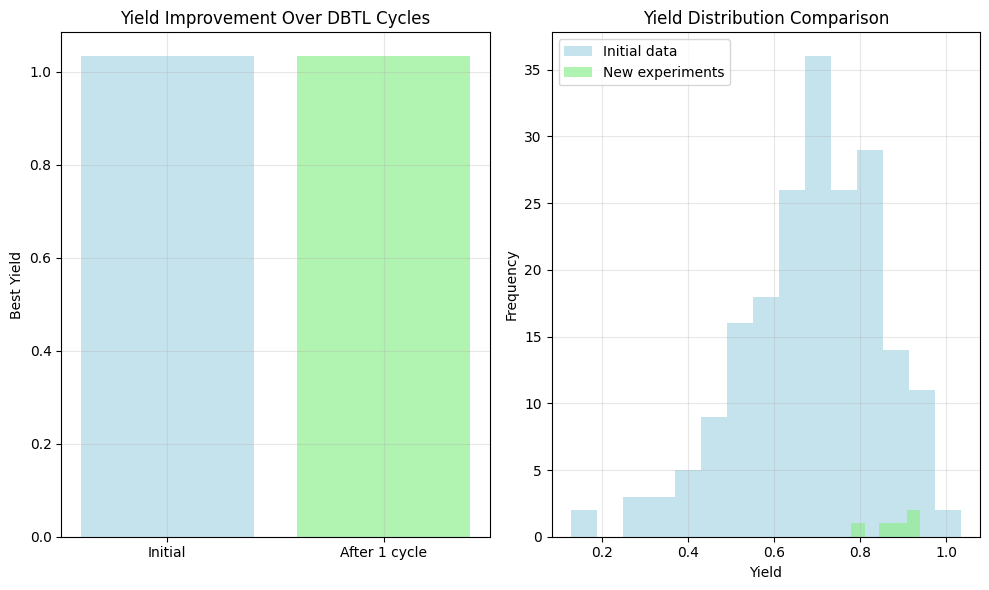


VAE + GP + BO DBTL PIPELINE COMPLETED SUCCESSFULLY!


In [8]:
# Demonstration: How to continue the DBTL loop
print("CONTINUING THE DBTL LOOP")
print("=" * 40)

# Simulate experimental results for the top candidates
print("5. Test phase - Simulating experimental results...")
simulated_new_yields = torch.tensor([0.85, 0.92, 0.78, 0.88, 0.94])  # Simulated experimental results

print("Experimental results for top candidates:")
for i, (design, yield_val) in enumerate(zip(top_designs, simulated_new_yields)):
    print(f"  Candidate {i+1}: Yield = {yield_val:.3f}")

# 6. Learn phase - Update the dataset and retrain
print("\n6. Learn phase - Updating dataset...")
# Add new designs and yields to training data
X_train_updated = torch.cat([X_train_tensor, top_designs])
y_train_updated = torch.cat([y_train_tensor, simulated_new_yields])

print(f"Updated training set size: {len(X_train_updated)} designs")
print(f"New best yield: {y_train_updated.max():.3f}")

# The cycle can now repeat:
# - Re-encode all designs (including new ones) to latent space
# - Retrain the GP with the updated dataset
# - Run Bayesian optimization again to find the next batch of candidates
# - Decode and test experimentally

print("\n7. Ready for next DBTL cycle!")
print("   - Re-encode all designs to latent space")
print("   - Retrain GP with updated dataset")
print("   - Run BO to find next batch of candidates")
print("   - Repeat until convergence or resource limits")

# Show improvement over iterations
print(f"\nImprovement achieved:")
print(f"  Initial best yield: {y_train_tensor.max():.3f}")
print(f"  After 1 DBTL cycle: {y_train_updated.max():.3f}")
print(f"  Improvement: {(y_train_updated.max() - y_train_tensor.max()):.3f}")

# Plot improvement
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(['Initial', 'After 1 cycle'], [y_train_tensor.max(), y_train_updated.max()], 
        color=['lightblue', 'lightgreen'], alpha=0.7)
plt.ylabel('Best Yield')
plt.title('Yield Improvement Over DBTL Cycles')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
all_yields = torch.cat([y_train_tensor, simulated_new_yields])
plt.hist(y_train_tensor.numpy(), bins=15, alpha=0.7, label='Initial data', color='lightblue')
plt.hist(simulated_new_yields.numpy(), bins=5, alpha=0.7, label='New experiments', color='lightgreen')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.title('Yield Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VAE + GP + BO DBTL PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)